In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time, random
import pickle

In [2]:
class Parameter:
    #mini-batch Gradient Descent parameters

    def __init__(self, n_batch, eta, n_epochs):
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

In [3]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def loadBatch(filename):
    cifar = unpickle(filename)

    X = cifar[b'data'].T  # numpy array of size dxN    
    y = np.array(cifar[b'labels'])  # vector of lables of size 1xN
    Y = np.zeros((10,X.shape[1]))  # matrix of KxN
    Y[y,np.arange(len(y))] = 1

    return X,Y,y

def initializeParams(n_nodes,n_class,seed=None):
    W = []
    b = []
    n_layer = len(n_nodes)
    n_in = n_nodes[0]
    for i in range(n_layer):
        if i<n_layer-1:
            n_out = n_nodes[i+1]           
        else: 
            n_out = n_class  # last output        
        W.append(np.random.randn(n_out,n_in)/np.sqrt(n_in))
        b.append(np.zeros((n_out,1)))
        n_in = n_out
        
    return W,b

In [4]:
def computeScore(X,W,b):
    s = np.dot(W,X) + b
    return s

def ReLu(s):
    return np.maximum(0,s)

def SoftMax(s):
    p = np.exp(s)/np.expand_dims(np.exp(s).sum(axis=0),axis=0)  # matrix of size KxN
    return p

def evaluateClassifier(X,W,b):
    n_layer = len(W)
    h = X
    H = []
    for i in range(n_layer-1):
        s = computeScore(h,W[i],b[i])
        h = ReLu(s)
        H.append(h)
    s = computeScore(h,W[-1],b[-1])
    P = SoftMax(s)
    return H,P

def computeAccuracy(X,y,W,b):
    H,P = evaluateClassifier(X,W,b)
    y_pred = np.argmax(P, axis=0)
    acc = np.sum(y==y_pred)/(len(y)+0.0)
    return acc

def computeCost(X,Y,W,b,lamb):
    H,P = evaluateClassifier(X,W,b)
    loss = np.sum(-np.log(np.diag(np.dot(Y.T,P))))/(X.shape[1]+0.0)
    cost = loss + lamb*sum([np.einsum('ij,ij', wi, wi) for wi in W])
    return loss, cost
    
def computeGradients(X,Y,W,b,lamb):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    H,P = evaluateClassifier(X,W,b)
    g = P-Y
    for i in range(len(W)-1):
        h = H[-1-i]
        grad_b.append(np.expand_dims(g.sum(axis=1),axis=1)/(N+0.0))
        grad_W.append(np.dot(g,h.T)/(N+0.0) + 2*lamb*W[-1-i])
             
        Ind = np.zeros(h.shape)
        Ind[h>0] = 1
        g = np.dot(W[-1-i].T,g)*Ind
    
    grad_b.append(np.expand_dims(g.sum(axis=1),axis=1)/(N+0.0))
    grad_W.append(np.dot(g,X.T)/(N+0.0) + 2*lamb*W[0])
    
    return list(reversed(grad_W)), list(reversed(grad_b))

def computeGradsNumSlow(X, Y, W, b, lamb, h):
    grad_W = []
    grad_b = []
    for k in range(len(W)):
        n_out,n_in = W[k].shape

        gw = np.zeros(W[k].shape)
        gb = np.zeros((n_out, 1))

        for i in range(len(b[k])):
            b[k][i] -= h
            l1,c1 = computeCost(X, Y, W, b, lamb)
            b[k][i] += 2*h
            l2,c2 = computeCost(X, Y, W, b, lamb)
            b[k][i] -= h
            gb[i] = (c2-c1)/(2*h)

        for i in range(n_out):
            for j in range(n_in):
                W[k][i,j] -= h
                l1,c1 = computeCost(X, Y, W, b, lamb)
                W[k][i,j] += 2*h
                l2,c2 = computeCost(X, Y, W, b, lamb)
                W[k][i,j] -= h
                gw[i,j] = (c2-c1)/(2*h)
        grad_W.append(gw)
        grad_b.append(gb)
    return grad_W, grad_b

def generateBatches(X,Y,n_batch):
    d,N = X.shape
    K = Y.shape[0]
    XBatch = np.zeros((d,n_batch,int(N/n_batch)))
    YBatch = np.zeros((K,n_batch,int(N/n_batch)))
    
    for i in range(int(N/n_batch)):
        i_start = i*n_batch
        i_end = (i+1)*n_batch
        XBatch[:,:,i] = X[:,i_start:i_end]
        YBatch[:,:,i] = Y[:,i_start:i_end]
    return XBatch, YBatch

def plotResults(x,y,name='loss',par='0'):
    fig = plt.figure()
    plt.plot(x,y[0],label='training '+name)
    plt.plot(x,y[1],label='validation '+name)
    plt.legend(loc=0)
    plt.xlabel('n_updates')
    plt.ylabel(name)
    fig.savefig('Figures/'+name+'_params'+par+'.pdf')
    plt.show()

# Plot W
def plotW(W,class_name,arg_par='0'):
    fig=plt.figure(figsize=(20,2))
    for i in range(10):
        im = W[i,:].reshape(3,32,32)
        img = np.transpose((im-np.min(im))/(np.max(im)-np.min(im)),(1,2,0))
        plt.subplot(1, 10, i+1)                 
        plt.title(class_name[i])
        plt.imshow(img)
        plt.axis('off')
                       
    plt.savefig('Figures/imW_params'+arg_par+'.pdf')
    plt.show()

# Check gradient computation
def checkGrads(X, Y, W, b, lamb, h=1e-6):
    eps = 1e-30
    error = 1e-6
    
    gW1,gb1 = computeGradsNumSlow(X,Y,W,b,lamb, h)
    gW2,gb2 = computeGradients(X,Y,W,b,lamb)
    
    total_error_w = 0
    total_error_b = 0
    max_w = np.zeros(len(W))
    max_b = np.zeros(len(W))
    
    for i in range(len(W)):
        error_w = np.abs(gW1[i]-gW2[i])/np.maximum(eps,np.abs(gW1[i])+np.abs(gW2[i]))
        error_b = np.abs(gb1[i]-gb2[i])/np.maximum(eps,np.abs(gb1[i])+np.abs(gb2[i]))
        total_error_w += np.sum(error_w>error)
        total_error_b += np.sum(error_b>error)
        max_w[i] = np.max(error_w)
        max_b[i] = np.max(error_b)
    print('The number of errors (relative error > 1e-6) of W:', total_error_w)
    print('The maximum of relative error of W:', np.max(max_w))
    print('The number of errors (relative error > 1e-6) of b:', total_error_b)
    print('The maximum of relative error of b:', np.max(max_b))
    
def plotCost(X,Y,y,W_train,b_train,lamb,step,name_par='0'):
    update = np.append(np.arange(0,len(W_train)-1,step),len(W_train)-1)
    n_update = len(update)
    loss_train = np.zeros(n_update)   
    loss_val = np.zeros(n_update)
    cost_train = np.zeros(n_update)   
    cost_val = np.zeros(n_update)
    error_train = np.zeros(n_update)   
    error_val = np.zeros(n_update)
    for ind,i in enumerate(update):
        loss_train[ind],cost_train[ind] = computeCost(X[0],Y[0],W_train[i],b_train[i],lamb)        
        loss_val[ind],cost_val[ind] = computeCost(X[1],Y[1],W_train[i],b_train[i],lamb)   
        
        error_train[ind] = computeAccuracy(X[0],y[0],W_train[i],b_train[i]) 
        error_val[ind] = computeAccuracy(X[1],y[1],W_train[i],b_train[i]) 
    plotResults(update,[loss_train, loss_val],'loss',name_par)
    plotResults(update,[cost_train, cost_val],'cost',name_par)
    plotResults(update,[error_train, error_val],'accuracy',name_par)
    
def normalize(trainX, valX, testX):
    mean_train = np.mean(trainX,axis=1).reshape(-1,1)
    std_train = np.std(trainX,axis=1).reshape(-1,1)
    trainX = (trainX-mean_train)/std_train
    valX = (valX-mean_train)/std_train
    testX = (testX-mean_train)/std_train
    return trainX, valX, testX

In [5]:
def miniBatchGD_(X,Y,y,GDparams,W,b,lamb,jitter=False):
    X_train = X[0]
    Y_train = Y[0]
    y_train = y[0]
    X_val = X[1]
    Y_val = Y[1]
    y_val = y[1]
    
    d,N = X_train.shape
    numBatches = int(np.floor(N/GDparams.n_batch))    
    if type(GDparams.eta) is np.ndarray: 
        eta = GDparams.eta        
    else:
        eta = np.zeros(GDparams.n_epochs*numBatches)
        eta[:] = GDparams.eta
        
    W_train = []
    b_train = []
    W_star = W[:]
    b_star = b[:]
    W_train.append(W_star[:])
    b_train.append(b_star[:])
    
    XBatch,YBatch = generateBatches(X_train,Y_train,GDparams.n_batch)
    
    t = 0
    for i in range(GDparams.n_epochs):
        for j in range(numBatches):           
            xTr = XBatch[:,:,j]
            yTr = YBatch[:,:,j] 
            if jitter:
                xTr = xTr + np.random.normal(0,0.01,XBatch[:,:,j].shape)
            
            grad_w,grad_b = computeGradients(xTr,yTr,W_star,b_star,lamb)
            # update the weights and the thresholds               
            for k in range(len(W)):
                W_star[k] = W_star[k] - eta[t]*grad_w[k]
                b_star[k] = b_star[k] - eta[t]*grad_b[k]               
            t += 1  
            W_train.append(W_star[:])
            b_train.append(b_star[:])
    
    return W_train,b_train

In [6]:
def cylicalEta(eta_min,eta_max,stepsize,n_cycle):
    iterations = np.arange(2*n_cycle*stepsize)
    cycle = np.floor(1 + iterations/(2*stepsize))
    x = np.abs(iterations/stepsize - 2*cycle + 1)
    eta = eta_min + (eta_max - eta_min)*np.maximum(0.0, (1-x))
    return eta

In [7]:
def ensemble_cyclical(XTe,yTe,W_train,b_train,step,n_cycle):
    acc = np.zeros(n_cycle)
    j = 0
    W = W_train[-1][:]
    b = b_train[-1][:]
    n_layer = len(W)
    for j in range(n_layer):
        for i in range(4*step,len(W_train)-1,2*step):                
            W[j] = W[j] + W_train[i][j]
            b[j] = b[j] + b_train[i][j]
        W[j] /= float(n_cycle-1)
        b[j] /= float(n_cycle-1)
        
    return W,b

In [8]:
# Use all data to train
path = 'Datasets-py/'
XTr_1,YTr_1,yTr_1 = loadBatch(path+'data_batch_1')  # Training set
XTr_2,YTr_2,yTr_2 = loadBatch(path+'data_batch_2') 
XTr_3,YTr_3,yTr_3 = loadBatch(path+'data_batch_3')
XTr_4,YTr_4,yTr_4 = loadBatch(path+'data_batch_4')
XTr_5,YTr_5,yTr_5 = loadBatch(path+'data_batch_5')
XTrain = np.concatenate((XTr_1, XTr_2, XTr_3, XTr_4, XTr_5), axis=1)
YTr = np.concatenate((YTr_1, YTr_2, YTr_3, YTr_4, YTr_5), axis=1)
yTr = np.concatenate((yTr_1, yTr_2, yTr_3, yTr_4, yTr_5))

XValid = XTrain[:,-5000:] 
YVa = YTr[:,-5000:]
yVa = yTr[-5000:]
XTrain = XTrain[:,:-5000] 
YTr = YTr[:,:-5000]
yTr = yTr[:-5000]

XTest,YTe,yTe = loadBatch(path+'test_batch')    # Test set

XTr, XVa, XTe = normalize(XTrain, XValid, XTest)

names = unpickle(path+'batches.meta')[b'label_names']  # list if size (10,1)

K = len(names)
class_name = []
for i in range(K):
    class_name.append(names[i].decode("utf-8"))

In [9]:
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

# Exercise 5:
## 5.1 Improvement

In this part I used the same hyper-parameter as the one used to train in the final model.

In [10]:
d,n = X[0].shape
n_batch = 100

eta_min = 1e-5
eta_max = 1e-1
n_s = int(2*np.floor(n/n_batch))

lamb = 0.00268647

n_node = 50
n_nodes = np.array([d, n_node])

In [13]:
# (c) - ensemble the local minimum at the end of each cycle
n_cycle = 6
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

W,b = initializeParams(n_nodes,K)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  172.3863160610199
The accuracy on test set:  52.25 %


In [ ]:
step = 300
name_par = 'best_6cycle'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [22]:
# (c) - ensemble the local minimum at the end of each cycle
W,b = ensemble_cyclical(XTe,yTe,W_train,b_train,n_s,n_cycle)
print('The accuracy ensemble on test set: ',computeAccuracy(XTe,yTe,W,b)*100,'%')

The accuracy ensemble on test set:  52.470000000000006 %


In [23]:
# (b) - train with more hidden nodes -> the regularization should be increased
n_node = 100
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

lamb = 0.003  # increase the regularization
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  121.95974087715149
The accuracy on test set:  53.400000000000006 %


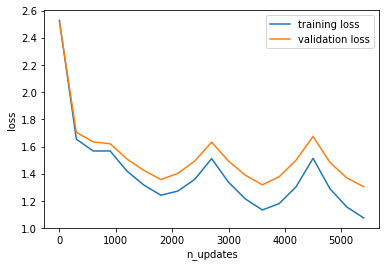

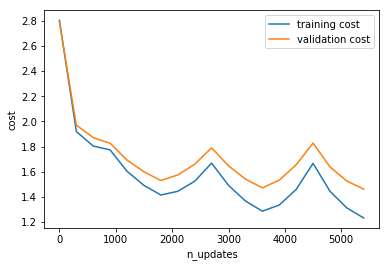

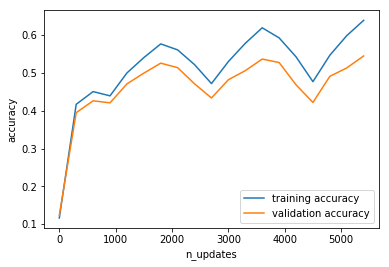

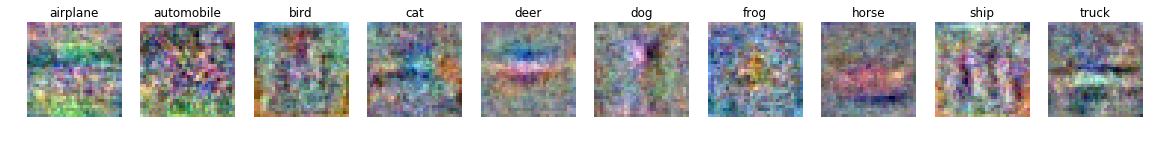

In [20]:
step = 300
name_par = 'impr_100nodes'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [21]:
# (b) - train with more hidden nodes -> the regularization should be increased
n_node = 200
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

lamb = 0.004  # increase the regularization
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  206.61468720436096
The accuracy on test set:  54.74 %


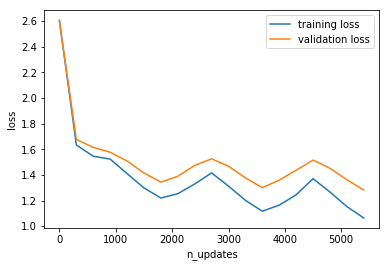

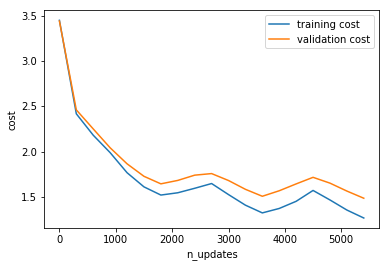

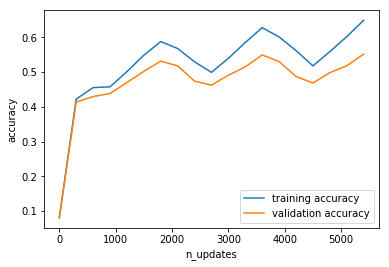

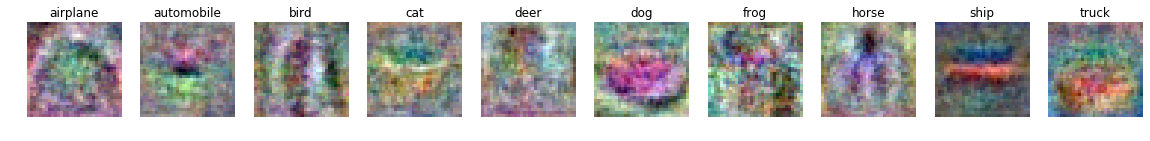

In [22]:
step = 300
name_par = 'impr_200nodes'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [32]:
# (b) + (c) - emsemble for model with more hidden layer
n_node = 100
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 6
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

lamb = 0.003
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  218.02771925926208
The accuracy on test set:  54.36 %


In [34]:
# (c) - ensemble the local minimum at the end of each cycle
W,b = ensemble_cyclical(XTe,yTe,W_train,b_train,n_s,n_cycle)
print('The accuracy ensemble on test set: ',computeAccuracy(XTe,yTe,W,b)*100,'%')

The accuracy ensemble on test set:  53.839999999999996 %


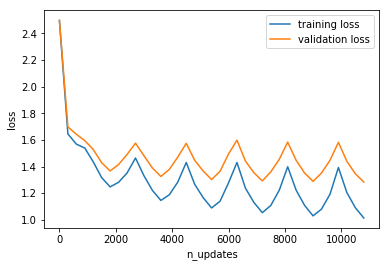

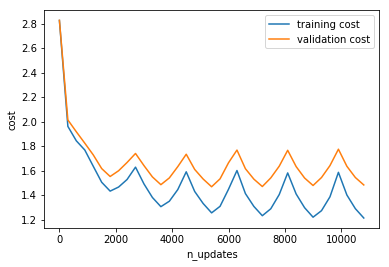

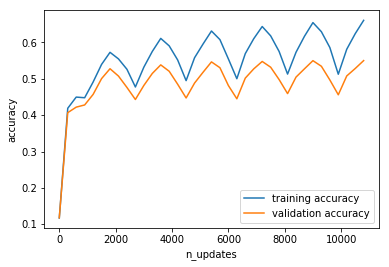

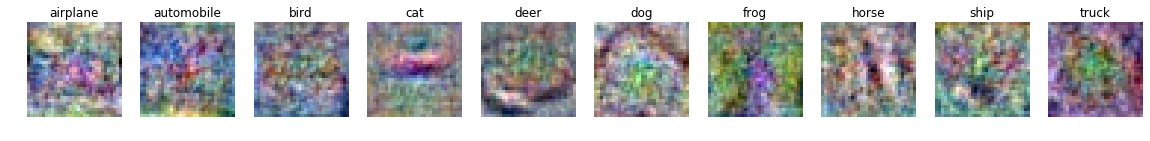

In [35]:
step = 300
name_par = 'impr_100nodes_6cycles'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [31]:
n_node = 50
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

lamb = 0.00268647 
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  95.713063955307
The accuracy on test set:  51.88 %


In [47]:
# (e) - jitter
n_node = 50
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

lamb = 0.00268647 
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb,jitter=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  118.97671890258789
The accuracy on test set:  51.64 %


In [48]:
# (e) + (b) - jitter
n_node = 100
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

lamb = 0.003
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb,jitter=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  151.79652309417725
The accuracy on test set:  53.43 %


In [49]:
step = 300
name_par = 'impr_jitter'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

KeyboardInterrupt: 

## 5.2 Find the boundary for learning rate

In [11]:
def findEta(X,Y,y,eta_range,nodes,lamb,name='0'):  
    eta_min = 0
    eta_max = 0
    n_batch = 100
    n_epochs = 8
    n_s = int(X[0].shape[1]/n_batch)*n_epochs
    n_cycle = 0.5
    eta = cylicalEta(eta_range[0],eta_range[1],n_s,n_cycle)
    
    W,b = initializeParams(nodes,K)
    
    GDparams = Parameter(n_batch,eta,n_epochs)
    
    W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
    loss_val = np.zeros(len(W_train))
    cost_val = np.zeros(len(W_train))
    
    loss_val[0],cost_val[0] = computeCost(X[1],Y[1],W_train[0],b_train[0],lamb)
    for i in range(1,len(W_train)):
        loss_val[i],cost_val[i] = computeCost(X[1],Y[1],W_train[i],b_train[i],lamb)
        diff = loss_val[i] - loss_val[i-1]
        if eta_min<1e-15 and diff<0:
            eta_min = eta[i-1]
        if eta_max<1e-15 and diff>0.1:
            eta_max = eta[i]
            
    return W_train, b_train, np.array([eta_min,eta_max]), loss_val, cost_val

In [12]:
eta_range = np.array((0,0.2))
W_train, b_train, range_out, loss_val, cost_val = findEta(X,Y,y,eta_range,n_nodes,lamb)

loss_val = loss_val[1:]
cost_val = cost_val[1:]

In [31]:
print(range_out)
print(int(X[0].shape[1]/n_batch)*8)

[5.55555556e-05 5.43888889e-02]
3600


In [16]:
n_batch = 100
n_epochs = 8
n_s = int(X[0].shape[1]/n_batch)*n_epochs
n_cycle = 0.5
eta = cylicalEta(eta_range[0],eta_range[1],n_s,n_cycle)
print(n_s)

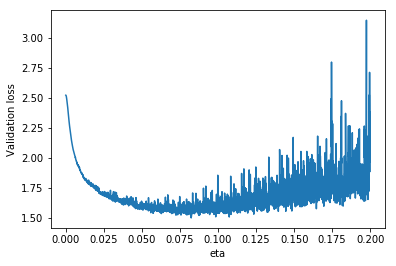

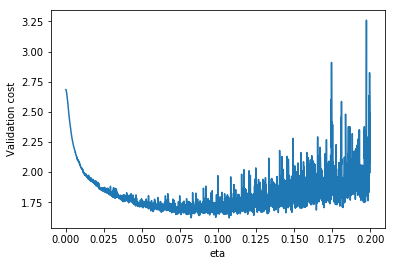

In [23]:
name = '0'

fig = plt.figure()
plt.plot(eta,loss_val)
plt.xlabel('eta')
plt.ylabel('Validation loss')
fig.savefig('Figures/etaSearch_loss'+name+'.pdf')
plt.show()

fig = plt.figure()
plt.plot(eta,cost_val)
plt.xlabel('eta')
plt.ylabel('Validation cost')
fig.savefig('Figures/etaSearch_cost'+name+'.pdf')
plt.show()

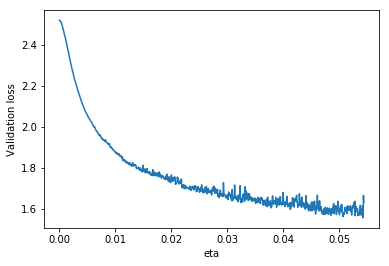

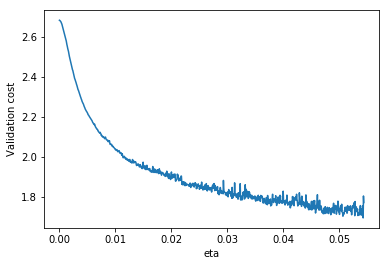

In [24]:
eps = 1e-15
#range_out = np.array([5.55555556e-5, 5.83888889e-2])
ind = (eta<(range_out[1]+eps)) & (eta>(range_out[0]-eps))

name = 'range'

fig = plt.figure()
plt.plot(eta[ind],loss_val[ind])
plt.xlabel('eta')
plt.ylabel('Validation loss')
fig.savefig('Figures/etaSearch_loss'+name+'.pdf')
plt.show()

fig = plt.figure()
plt.plot(eta[ind],cost_val[ind])
plt.xlabel('eta')
plt.ylabel('Validation cost')
fig.savefig('Figures/etaSearch_cost'+name+'.pdf')
plt.show()

In [39]:
# Train network with new range
n_node = 50
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)

n_cycle = 3
n_s = int(2*np.floor(n/n_batch))
#range_out = np.array([5.55555556e-5, 5.83888889e-2])
eta = cylicalEta(range_out[0],range_out[1],n_s,n_cycle)

lamb = 0.00268647 
n_epochs = int(2*n_cycle*n_s/n*n_batch)
GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD_(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  160.1808488368988
The accuracy on test set:  51.5 %


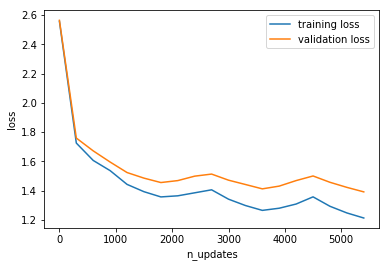

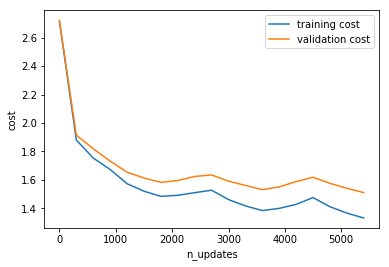

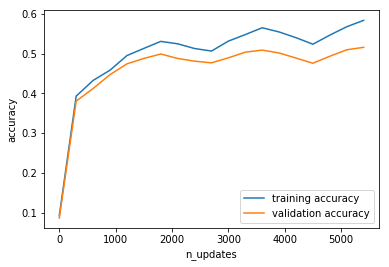

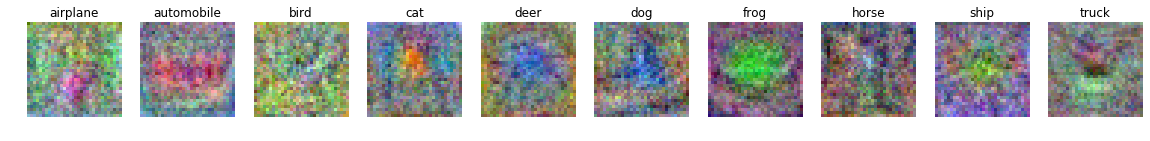

In [40]:
step = 300
name_par = 'lr_final'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [72]:
print(eta[ind][:10])

[5.55555556e-05 1.11111111e-04 1.66666667e-04 2.22222222e-04
 2.77777778e-04 3.33333333e-04 3.88888889e-04 4.44444444e-04
 5.00000000e-04 5.55555556e-04]


In [66]:
print(eta[:10])

[0.00000000e+00 5.55555556e-05 1.11111111e-04 1.66666667e-04
 2.22222222e-04 2.77777778e-04 3.33333333e-04 3.88888889e-04
 4.44444444e-04 5.00000000e-04]


In [74]:
from scipy.interpolate import make_interp_spline, BSpline

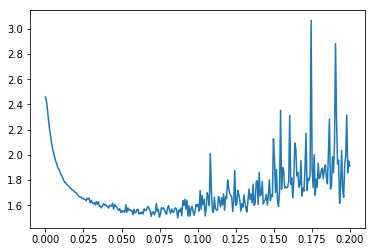

In [99]:
xnew = np.linspace(eta.min(),eta.max(),300)
spl = make_interp_spline(eta, loss_val, k=3) #BSpline object
power_smooth = spl(xnew)

plt.plot(xnew,power_smooth)
plt.show()